<a href="https://colab.research.google.com/github/shobhit020/BDSN-SPARK-ASSIGNMENT/blob/main/BDSN_ASSIGNMENT_SHOBHIT_SHARMA_A21030.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://4.bp.blogspot.com/-gbL5nZDkpFQ/XScFYwoTEII/AAAAAAAAAGY/CcVb_HDLwvs2Brv5T4vSsUcz7O4r2Q79ACK4BGAYYCw/s1600/kk3-header00-beta.png)<br>

# BDSN ASSIGNMENT


---


### SHOBHIT SHARMA - A21030


**Dataset can be found here [Data](https://www.kaggle.com/ealaxi/paysim1)**



# Part 1: Create environment

In [ ]:
!apt -q update > /dev/null
!apt -q install openjdk-11-jdk-headless -qq > /dev/null



---

Install the Latest version of spark and Hadoop and create environment to run spark

In [ ]:
# Get latest and correct version of Spark

# if the current version of Spark is not used, there may be errors

!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

!tar xf spark-3.2.1-bin-hadoop3.2.tgz

!pip -q install pyspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 46.6 MB/s 


Here we have used version 11 of java and latest version of spark as some of the features were not working in older versions. 



---



**Initiating the Spark Session and Context**


Ignore unnecessary warnings and we will import all the useful libraries.

importing * so that we can use any of the package in a particular library.   

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from pyspark.sql.types import *
from string import *
from pyspark.sql.functions import *
from pyspark.sql import *

# note UI port switched from default 4040 to 4050 to avoid clash with ngrok
spark = SparkSession.builder.master("local[*]").config('spark.ui.port', '4050').getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [ ]:
spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = spark.read.csv("/content/drive/MyDrive/PS_20174392719_1491204439457_log.csv",header=True,inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



We will chaneg the Schema of the dataset as some of the columns are not in the right format.

In [ ]:
Schema = StructType([StructField("step", IntegerType(), True),
                                StructField("type", StringType(), True),
                                StructField("amount", FloatType(), True),
                                StructField("nameOrig", StringType(), True),
                                StructField("oldbalanceOrig", FloatType(), True),
                                StructField("newbalanceOrig", FloatType(), True),
                                StructField("nameDest", StringType(), True),
                                StructField("oldbalanceDest", FloatType(), True),
                                StructField("newbalanceDest", FloatType(), True),
                                StructField("isFraud", IntegerType(), True),
                                StructField("isFlaggedFraud", IntegerType(), True)])

Now import the dataset again with new defined Schema. 

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/PS_20174392719_1491204439457_log.csv',
                    schema=Schema,
                    inferSchema=True,
                    header=True).cache()

In [ ]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: float (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrig: float (nullable = true)
 |-- newbalanceOrig: float (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: float (nullable = true)
 |-- newbalanceDest: float (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



Cache means to load the dataset in Cache memory so that we can load the results quickly when various different functions are applied on as Cache memory is the fastest available memory.

In [ ]:
df.is_cached

True

In [ ]:
df.limit(3).toPandas()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0


In [ ]:
df.groupBy('isFraud').count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+



# Part 2: Data Cleaning

The purpose of data cleaning is to check if there is any invalid or missing values, and eliminate those reords.

Print the datatype for each column.

In [ ]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: float (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrig: float (nullable = true)
 |-- newbalanceOrig: float (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: float (nullable = true)
 |-- newbalanceDest: float (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



We need to check each column for invalid values. The set of invalid values depends on the data type of the columns:
1. For columns with string type: empty or null values.
2. Otherwise: null or minus values.

Firstly, we need to get columns that has 'string' datatype and store it in a variable.

In [ ]:
stringCols = []
for (colName, colType) in df.dtypes:
    if(colType == 'string'):
        stringCols.append(colName)
        
print(stringCols)

['type', 'nameOrig', 'nameDest']


Then, we count the number of invalid values in each column and show the result.

In [ ]:
def isInvalidValue(colName):
    if colName in stringCols:
        return (col(colName).isNull() | (col(colName) == ''))
    else:
        return (col(colName).isNull() | (col(colName) < 0))

In [ ]:
df.select([count(when(isInvalidValue(c), c)).alias(c) for c in df.columns]).show()

+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrig|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|             0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+--------------+



As shown, the dataset does not contain any invalid values so we do not need to elminate any records.

# **Part 3: Exploring the dataset**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd_df = pd.read_csv("/content/drive/MyDrive/PS_20174392719_1491204439457_log.csv")

#### **3.1 Correlation**

In [ ]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: float (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrig: float (nullable = true)
 |-- newbalanceOrig: float (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: float (nullable = true)
 |-- newbalanceDest: float (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [ ]:
df.show(5)

+----+--------+--------+-----------+--------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrig|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+--------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|      170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|       21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|         181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|         181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|       41554.0|      29885.86|M123070170

In [ ]:
df_1 =df.select('step',
                'amount',
                'oldbalanceOrig',
                'newbalanceOrig',
                'oldbalanceDest',
                'newbalanceDest',
                'isFraud',
                'isFlaggedFraud')

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
feature_col = ['step',
               'amount',
               'oldbalanceOrig',
               'newbalanceOrig',
               'oldbalanceDest',
               'newbalanceDest',
               'isFraud',
               'isFlaggedFraud']

assembler = VectorAssembler(inputCols=feature_col, outputCol="features")
assembled_df = assembler.transform(df_1)
assembled_df.show(10, truncate=False)

+----+--------+--------------+--------------+--------------+--------------+-------+--------------+---------------------------------------------------------------------------+
|step|amount  |oldbalanceOrig|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|features                                                                   |
+----+--------+--------------+--------------+--------------+--------------+-------+--------------+---------------------------------------------------------------------------+
|1   |9839.64 |170136.0      |160296.36     |0.0           |0.0           |0      |0             |(8,[0,1,2,3],[1.0,9839.6396484375,170136.0,160296.359375])                 |
|1   |1864.28 |21249.0       |19384.72      |0.0           |0.0           |0      |0             |(8,[0,1,2,3],[1.0,1864.280029296875,21249.0,19384.720703125])              |
|1   |181.0   |181.0         |0.0           |0.0           |0.0           |1      |0             |(8,[0,1,2,6],[1.0,181.0,181

In [ ]:
from pyspark.ml.stat import Correlation
correlation_matrix = Correlation.corr(assembled_df, "features")

In [ ]:
corr_list = correlation_matrix.head()[0].toArray().tolist()
pearson_corr_df = spark.createDataFrame(corr_list,schema=['step',
                                                           'amount',
                                                           'oldbalanceOrig',
                                                           'newbalanceOrig',
                                                           'oldbalanceDest',
                                                           'newbalanceDest',
                                                           'isFraud',
                                                           'isFlaggedFraud'])
pearson_corr_df.show(truncate=False)

+---------------------+----------------------+----------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|step                 |amount                |oldbalanceOrig        |newbalanceOrig       |oldbalanceDest       |newbalanceDest       |isFraud              |isFlaggedFraud       |
+---------------------+----------------------+----------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|1.0                  |0.022372994659267096  |-0.010058378355268656 |-0.0102990369734248  |0.027665359566649304 |0.025888175678812735 |0.031577568632326324 |0.003277415392342152 |
|0.022372994659267096 |1.0                   |-0.0027624747622711264|-0.007860925283278471|0.29413745005192504  |0.4593042671203274   |0.07668842885311837  |0.01229460240431322  |
|-0.010058378355268656|-0.0027624747622711264|1.0                   |0.9988027631725764   |0.0662425

In [ ]:
pearson_corr_df.toPandas().set_index(keys = [['step','amount','oldbalanceOrig','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']])

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrig,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


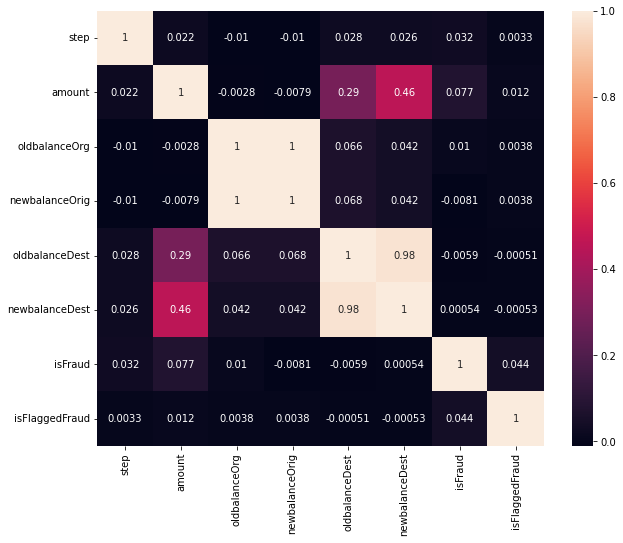

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(pd_df.corr(),annot=True)

####**3.2 General Statistics**

Here are some general statistics to give us a better idea of how the data looks like. First, let's take a look at the distribution of transaction type.

In [ ]:
df.agg(countDistinct('type')).show()

+-----------+
|count(type)|
+-----------+
|          5|
+-----------+



In [ ]:
df.crosstab('type','isfraud').show()

+------------+-------+----+
|type_isfraud|      0|   1|
+------------+-------+----+
|    TRANSFER| 528812|4097|
|       DEBIT|  41432|   0|
|     CASH_IN|1399284|   0|
|    CASH_OUT|2233384|4116|
|     PAYMENT|2151495|   0|
+------------+-------+----+



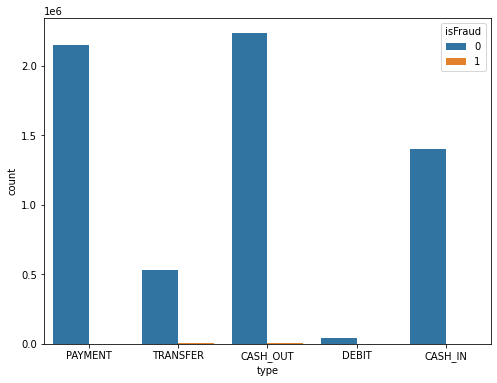

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='type', data=pd_df, hue='isFraud')

In [ ]:
df.select('type').groupBy('type').count().show()

+--------+-------+
|    type|  count|
+--------+-------+
|TRANSFER| 532909|
| CASH_IN|1399284|
|CASH_OUT|2237500|
| PAYMENT|2151495|
|   DEBIT|  41432|
+--------+-------+



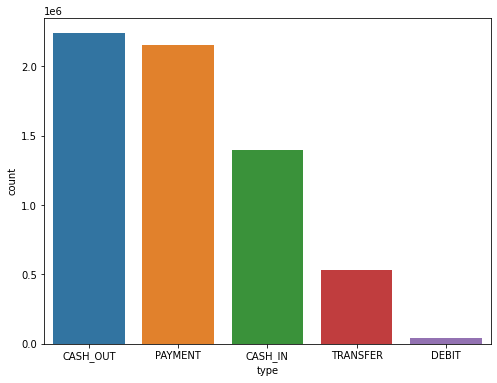

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='type',data=pd_df, order=pd_df['type'].value_counts().index)

Next we will look at the transaction amounts.

In [ ]:
print('Statistics of all transaction amounts:')
df.describe('amount').show()

Statistics of all transaction amounts:
+-------+-----------------+
|summary|           amount|
+-------+-----------------+
|  count|          6362620|
|   mean|179861.9035579989|
| stddev|603858.2316772637|
|    min|              0.0|
|    max|       9.244552E7|
+-------+-----------------+



In [ ]:
fraudulentTransactions = df.filter(df.isFraud == 1)
print('Statistics of fraudulent transaction amounts:')
fraudulentTransactions.describe('amount').show()

Statistics of fraudulent transaction amounts:
+-------+-----------------+
|summary|           amount|
+-------+-----------------+
|  count|             8213|
|   mean|1467967.299835128|
| stddev|2404252.947526679|
|    min|              0.0|
|    max|            1.0E7|
+-------+-----------------+



####**3.1 Number and percentage of fraudulent transactions**

In [ ]:
fraudulentTransactionsCount = fraudulentTransactions.count()
print("The total number of fraudulent records = ", fraudulentTransactionsCount)
print("The percentage of fraudulent records = %f%%" % ( float(fraudulentTransactions.count())/df.count()*100))

The total number of fraudulent records =  8213
The percentage of fraudulent records = 0.129082%


This shows that there are only 0.12 % of the fraudulent data in our dataset.

####**3.3 Types of the fraudulent transactions**

In [ ]:
fraudulentTransactions.groupBy(fraudulentTransactions.type).count().show()

+--------+-----+
|    type|count|
+--------+-----+
|TRANSFER| 4097|
|CASH_OUT| 4116|
+--------+-----+



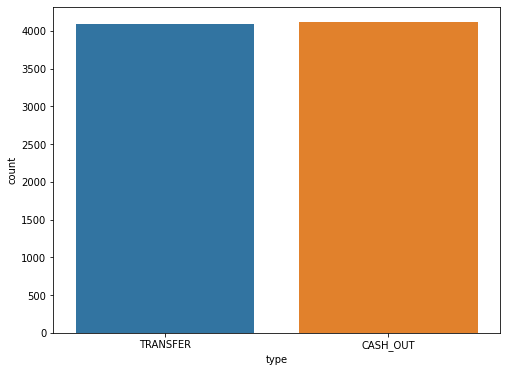

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='type', data=pd_df[pd_df['isFraud']==1])

We can see there are two fradulent types of transactions, `CASH_OUT` and `TRANSFER`.

In [ ]:
df.groupby('isFlaggedFraud').count().show()

+--------------+-------+
|isFlaggedFraud|  count|
+--------------+-------+
|             0|6362604|
|             1|     16|
+--------------+-------+



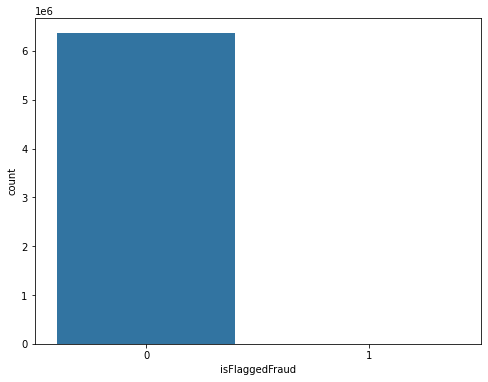

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='isFlaggedFraud',data=pd_df)

Only 16 values have been flagged fraud

####**3.4 What determines whether the feature `isFlaggedFraud` gets set or not?**

In the overview of the dataset, `isFlaggedFraud` is defined as: "An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction." Now, we will check if the dataset agrees to the description given.

In [ ]:
df.filter(df['isFlaggedFraud'] == 1).orderBy('amount').show(5, truncate=False)

+----+--------+---------+-----------+--------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|type    |amount   |nameOrig   |oldbalanceOrig|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+--------------+--------------+-----------+--------------+--------------+-------+--------------+
|586 |TRANSFER|353874.22|C1684585475|353874.22     |353874.22     |C1770418982|0.0           |0.0           |1      |1             |
|646 |TRANSFER|399045.1 |C724693370 |1.0399045E7   |1.0399045E7   |C1909486199|0.0           |0.0           |1      |1             |
|279 |TRANSFER|536624.44|C1035541766|536624.44     |536624.44     |C1100697970|0.0           |0.0           |1      |1             |
|250 |TRANSFER|1343002.1|C1100582606|1343002.1     |1343002.1     |C1147517658|0.0           |0.0           |1      |1             |
|617 |TRANSFER|2542664.2|C786455622 |2542664.2     |2542664.2     |C6

**Check the min and max of the values when it's flagged as fraud**

In [ ]:
max1 = df.filter(df['isFlaggedFraud'] == 1).agg({"amount": "max"}).collect()[0]
min1 = df.filter(df['isFlaggedFraud'] == 1).agg({"amount": "min"}).collect()[0]

In [ ]:
max1 = df.filter(df['isFlaggedFraud'] == 1).agg({"amount": "mean"}).collect()[0]

In [ ]:
df.groupBy(['isFlaggedFraud']).agg({'amount':'avg','isFlaggedFraud':'count'}).show()

+--------------+------------------+---------------------+
|isFlaggedFraud|       avg(amount)|count(isFlaggedFraud)|
+--------------+------------------+---------------------+
|             0|179850.13042664138|              6362604|
|             1|   4861597.6953125|                   16|
+--------------+------------------+---------------------+



***Insight*** - we can clearly see that though there are only 16 cases of frauds, the average amount is very high almost 27 times the average amount of non-fraudulent customers.

In [ ]:
df.limit(3).toPandas()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0


**We know that fraudulent transactions only take form in 'CASH_OUT' and 'TRANSFER'. Therefore, we can skip checking other type of transactions.**

In [ ]:
new_dF = df.filter((df.type == 'CASH_OUT') | (df.type == 'TRANSFER'))
print('Size of new dataset: ', new_dF.count())

Size of new dataset:  2770409


**We found that the columns isFlaggedFraud, nameOrig and nameDest do not help in predicting fraudulent transactions. Therefore, we will not use those columns for training our model.**

In [ ]:
new_dF = new_dF.drop('isFlaggedFraud').drop('nameOrig').drop('nameDest')

Since we will not use df anymore, we can uncache it.

In [ ]:
df.unpersist()

DataFrame[step: int, type: string, amount: float, nameOrig: string, oldbalanceOrig: float, newbalanceOrig: float, nameDest: string, oldbalanceDest: float, newbalanceDest: float, isFraud: int, isFlaggedFraud: int]

# Part 4: Constructing the fraud detection model

#### **4.1 Transforming the data**

To use the machine learning algorithms provided by MlLib, we have to do a few transformations on our input data:
1. Convert the label column (i.e., 'isFraud') to doubleType.
2. Convert the categorical attributes into numeric attributes. The only categorical attribute that we will use is 'type'.
3. Combine the values of all feature/attribute columns into a feature vector.
4. Pass the feature vector through vector indexer to differentiate between categorical and continuous attribute.

Import necessary Machine Learning libraries

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Cast class column 'isFraud' from intType to doubleType
labelIndexer = StringIndexer(inputCol="isFraud", outputCol="label")

# Convert categorical column 'type' to numerical index
typeIndexer = StringIndexer(inputCol="type", outputCol="typeIndex")

In [ ]:
# Specify the feature columns - a parameter for featureAssembler
featuresCols = new_dF.columns
featuresCols.remove('isFraud') 
featuresCols.remove('type')

***VectorAssembler*** is a transformer that combines a given list of columns into a single vector column.

**VectorIndexer** helps index categorical features in datasets of Vectors.

In [ ]:
featureAssembler = VectorAssembler(inputCols=featuresCols, 
                                   outputCol="featuresVec")

featureIndexer = VectorIndexer(inputCol="featuresVec", 
                               outputCol="features",
                               maxCategories=5)

***Pipeline*** - ML Pipelines are built on top of DataFrames and combine multiple algorithms into a single pipeline, or workflow and help users create and tune their algorithms.

In [ ]:
pipeline = Pipeline(stages=[labelIndexer, 
                            typeIndexer, 
                            featureAssembler, 
                            featureIndexer])

In [ ]:
pipelineModel = pipeline.fit(new_dF)

In [ ]:
data = pipelineModel.transform(new_dF)

In [ ]:
data.limit(3).toPandas()

,step,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,label,typeIndex,featuresVec,features
0,1,TRANSFER,181.0000,181.0,0.0,0.0,0.000000,1,1.0,1.0,"[1.0, 181.0, 181.0, 0.0, 0.0, 0.0]","[1.0, 181.0, 181.0, 0.0, 0.0, 0.0]"
1,1,CASH_OUT,181.0000,181.0,0.0,21182.0,0.000000,1,1.0,0.0,"[1.0, 181.0, 181.0, 0.0, 21182.0, 0.0]","[1.0, 181.0, 181.0, 0.0, 21182.0, 0.0]"
2,1,CASH_OUT,229133.9375,15325.0,0.0,5083.0,51513.441406,0,0.0,0.0,"[1.0, 229133.9375, 15325.0, 0.0, 5083.0, 51513...","[1.0, 229133.9375, 15325.0, 0.0, 5083.0, 51513..."


####**4.2 Splitting the data**

We need to divide our transformed input data into two sets:
1. **Training set**: for training the models
2. **Testing set**: for evaluating the models

Here we will split the data randomly with proportion of 70% training set and 30% testing set.

In [ ]:
(trainingData, testingData) = data.randomSplit([0.7, 0.3])

In [ ]:
trainingData.cache()
testingData.cache()

DataFrame[step: int, type: string, amount: float, oldbalanceOrig: float, newbalanceOrig: float, oldbalanceDest: float, newbalanceDest: float, isFraud: int, label: double, typeIndex: double, featuresVec: vector, features: vector]

***Creating an accuracy evaluator for our model***

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label',
                                              predictionCol="prediction",
                                              metricName="accuracy")

####**4.3 Exploring the classifier models**

In this part, we are going to explore two classifiers that are supported by MlLib: Random Forest and Logistic Regression.

After obtaining the trained models, we will use them to make predictions on the testing data and evaluate their performance using BinaryClassificationEvaluator. 

The BinaryClassificationEvaluator supports two evaluation metric: areaUnderROC(recall-specifity) and areaUnderPR(precision-recall). Since we are more interested in the positive class which denotes fraud, we are going to use areaUnderPR.

**1. Logistic Regression**



In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
lr = LogisticRegression(maxIter=100,
                        regParam=0.3,
                        elasticNetParam=0.1,
                        featuresCol="features",
                        family = "binomial",
                        labelCol='label')

In [ ]:
lrModel = lr.fit(trainingData)

In [ ]:
lrPredictions = lrModel.transform(testingData)

In [ ]:
lr_accuracy = evaluator.evaluate(lrPredictions)
print("Accuracy of LogisticRegression is = %g"%(lr_accuracy))
print("Test Error of LogisticRegression = %g "%(1.0 - lr_accuracy))

Accuracy of LogisticRegression is = 0.997023
Test Error of LogisticRegression = 0.00297678 


**2. Linear Support Vector Machine**

In [ ]:
from pyspark.ml.classification import LinearSVC

In [ ]:
lsvc = LinearSVC(maxIter=10,
                 regParam=0.1,
                 featuresCol="features",
                 labelCol='label')

In [ ]:
lsvcModel = lsvc.fit(trainingData)

In [ ]:
predDF_lsvc = lsvcModel.transform(testingData)

In [ ]:
lsvm_accuracy = evaluator.evaluate(predDF_lsvc)
print("Accuracy of LogisticRegression is = %g"%(lsvm_accuracy))
print("Test Error of LogisticRegression = %g "%(1.0 - lsvm_accuracy))

Accuracy of LogisticRegression is = 0.997311
Test Error of LogisticRegression = 0.00268898 


**3. Naive Bayes**

In [ ]:
from pyspark.ml.classification import NaiveBayes

In [ ]:
nb = NaiveBayes(smoothing=1.0,
                modelType="gaussian",
                featuresCol="features", 
                labelCol='label')

In [ ]:
nbModel = nb.fit(trainingData)

In [ ]:
predDF_nb = nbModel.transform(testingData)

In [ ]:
nb_accuracy = evaluator.evaluate(predDF_nb)
print("Accuracy of Naïve Bayes is = %g"%(nb_accuracy))
print("Error of Naïve Bayes is = %g "%(1.0 - nb_accuracy))

Accuracy of Naïve Bayes is = 0.985163
Error of Naïve Bayes is = 0.0148369 


**4. Decision Tree**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol='label',
                            featuresCol="features",
                            impurity="gini")

In [ ]:
dtModel = dt.fit(trainingData)

In [ ]:
predDF_dt = dtModel.transform(testingData)

In [ ]:
dt_accuracy = evaluator.evaluate(predDF_dt)
print("Accuracy of Decision Tree is = %g"%(dt_accuracy))
print("Error of Decision Tree is = %g "%(1.0 - dt_accuracy))

Accuracy of Decision Tree is = 0.998258
Error of Decision Tree is = 0.00174248 


**5. Random Forest Classifier**



In [ ]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol='label',
                            featuresCol="features",
                            numTrees=50)

In [ ]:
rfModel = rf.fit(trainingData)

In [ ]:
# Make predictons on test data using the trained model
rfPredictions = rfModel.transform(testingData)

In [ ]:
rf_accuracy = evaluator.evaluate(rfPredictions)
print("Accuracy of Random Tree is = %g"%(rf_accuracy))
print("Error of Random Tree is = %g "%(1.0 - rf_accuracy))

Accuracy of Random Tree is = 0.998229
Error of Random Tree is = 0.00177138 


## Part 5: Conclusion

In [ ]:
print('Accuracy of Logistic Regression is :', lr_accuracy)
print('Accuracy of Linear Support Vector Machine is :', lsvm_accuracy)
print('Accuracy of Naive Bayes is :', nb_accuracy)
print('Accuracy of Decision Tree Classifier is :', dt_accuracy)
print('Accuracy of Random Forest Classifier is :', rf_accuracy)

Accuracy of Logistic Regression is : 0.9970232181757096
Accuracy of Linear Support Vector Machine is : 0.9973110219200484
Accuracy of Naive Bayes is : 0.9851630546694652
Accuracy of Decision Tree Classifier is : 0.9982575229369951
Accuracy of Random Forest Classifier is : 0.9982286221425845


In [ ]:
dict = {'Logistic Regression' : lr_accuracy,
        'Linear Support Vector Machine' : lsvm_accuracy,
       'Naive Bayes':nb_accuracy,
       'Decision Tree Classifier':dt_accuracy,
       'Random Forest Classifier': rf_accuracy,
        }

In [ ]:
dff = pd.DataFrame(index= dict.keys(), data = dict.values(), columns=['Accuracy']).sort_values(by=['Accuracy'],ascending= False)
dff


,Accuracy
Decision Tree Classifier,0.998258
Random Forest Classifier,0.998229
Linear Support Vector Machine,0.997311
Logistic Regression,0.997023
Naive Bayes,0.985163


In [ ]:
print('THEREFORE THE BEST MODEL IS "{}" \nWITH AN Accuracy OF "{}"'.format(dff['Accuracy'].idxmax(), dff['Accuracy'].max()))

THEREFORE THE BEST MODEL IS "Decision Tree Classifier" 
WITH AN Accuracy OF "0.9982575229369951"


Comparing the 5 classifiers, we conclude that DECISION TREE CLASSIFIER is the best model among 5 as it generates the highest accuracy score.
In the future, it is possible to further test on other models, and adjust some hyperparameters to fine tune the model.